In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import multigrate as mtg

# Load data

In [2]:
ref=sc.read('../data/test_protein/adata1.h5ad')
cite=sc.read('../data/test_protein/cite1.h5ad')
query=sc.read('../data/test_protein/adata2.h5ad')
query_protein=sc.read('../data/test_protein/cite2.h5ad')

# Configure and train the model

In [3]:
model = mtg.models.MultiVAE_PoE_cond(
    adatas=[[ref, query], [cite]],
    names=[['rna1', 'rna2'], ['cite1']],
    pair_groups=[["pair1", "pair2"], ["pair1"]],
    condition=True,
    z_dim=20,
    h_dim=32,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    losses=['nb', 'mse'],
    shared_hiddens=[],
    recon_coef=1,
    kl_coef=1e-6,
    integ_coef=0.1,
    cycle_coef=0,
    dropout=0.2,
)

In [4]:
model.train(
    n_iters=20000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    kl_anneal_iters=10000,
    validate_every=2000,
    verbose=1
)

 |████████████████████| 100.0% iter=20000/20000, time=147.45(s), loss=0.7367, recon=0.7270, kl=257.6890, integ=0.0939, cycle=0.0000, val_loss=0.7249, val_recon=0.7130, val_kl=248.7051, val_integ=0.1166, val_cycle=0.0000

In [5]:
out = model.test(
            adatas=[[ref, query], [cite]],
            names=[['rna1', 'rna2'], ['cite1']],
            pair_groups=[["pair1", "pair2"], ["pair1"]],
            batch_size=64
        )

In [6]:
integrated, latent, corrected, hs = out
sc.pp.neighbors(integrated)
sc.tl.umap(integrated)

... storing 'modality' as categorical
... storing 'study' as categorical


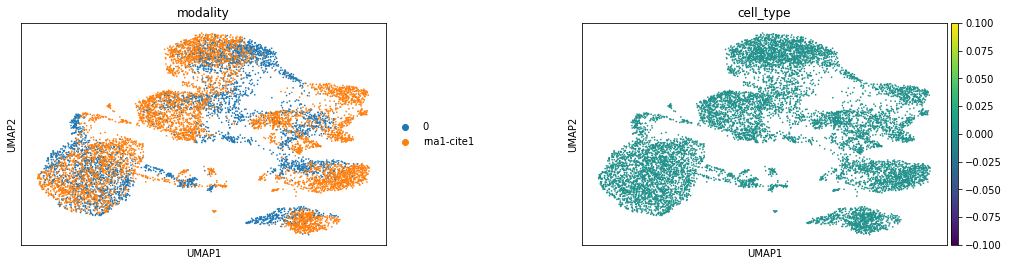

In [7]:
sc.pl.umap(integrated, color=['modality', 'cell_type'], ncols=2, wspace=0.4)

In [8]:
z = model.impute([[query],[]],
        names=[['rna2'], []],
        pair_groups = [[1], []],
        target_modality = 1,
        target_pair=None,
        batch_labels = [[1], []],
        batch_size = 64)
z

AnnData object with n_obs × n_vars = 3994 × 14
    obs: 'modality', 'barcode', 'cell_type', 'batch'

In [9]:
z.obsm['predicted_protein'] = z.X
z

AnnData object with n_obs × n_vars = 3994 × 14
    obs: 'modality', 'barcode', 'cell_type', 'batch'
    obsm: 'predicted_protein'

In [10]:
from scipy.stats import pearsonr

protein_corrs = []
for i, protein in enumerate(query_protein.var_names):
    protein = protein[:-10]
    protein_corrs.append(protein + ': Corr=' + str(np.round(pearsonr(z.obsm['predicted_protein'][:, i], query_protein.obsm['protein'][:, i])[0], 3)))
    
protein_corrs

['CD3: Corr=0.932',
 'CD4: Corr=0.848',
 'CD8a: Corr=0.696',
 'CD14: Corr=0.974',
 'CD15: Corr=0.504',
 'CD16: Corr=0.787',
 'CD56: Corr=0.797',
 'CD19: Corr=0.963',
 'CD25: Corr=0.421',
 'CD45RA: Corr=0.856',
 'CD45RO: Corr=0.788',
 'PD-1: Corr=0.422',
 'TIGIT: Corr=0.569',
 'CD127: Corr=0.85']

In [11]:
protein_corrs = pd.DataFrame()
for i, protein in enumerate(query_protein.var_names):
    value = np.round(pearsonr(z.obsm['predicted_protein'][:, i], query_protein.obsm['protein'][:, i])[0], 3)
    protein = protein[:-10]
    protein_corrs = protein_corrs.append({'protein': protein, 'correlation': value}, ignore_index=True)

protein_corrs = protein_corrs.append({'protein': 'mean', 'correlation': protein_corrs['correlation'].mean().round(3)}, ignore_index=True)
protein_corrs = protein_corrs.set_index('protein')
protein_corrs

,correlation
protein,
CD3,0.932
CD4,0.848
CD8a,0.696
CD14,0.974
CD15,0.504
CD16,0.787
CD56,0.797
CD19,0.963
CD25,0.421
